## Predicting Wine Scores from Text Descriptions 

Accompanying medium article 

### Loading the data

In [15]:
import pandas as pd 
import os 

data = pd.read_csv("winemag-data_first150k.csv", index_col = False)

### Examining data integrity at a high level

In [41]:
# Wine points are between 80 to 100 (the scale they use is from 1-100); this is skewed to the right 
# From my limited experience with wine, prices seem shifted to the right as well

data.describe()

,Unnamed: 0,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


In [7]:
# No missing entries for points and description
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


## Exploratory Data Analysis

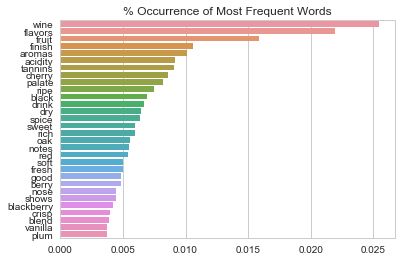

In [87]:
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

# set seaborn style 
sns.set(style="whitegrid")

stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()

def clean_description(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

data["cleaned_description"] = data["description"].apply(clean_description)

word_occurrence = data["cleaned_description"].str.split(expand=True).stack().value_counts()

total_words = sum(word_occurrence)

# plot most common words 

top_words = word_occurrence[:30]/total_words

ax = sns.barplot(x = top_words.values, y = top_words.index)

# Setting title 
ax.set_title("% Occurrence of Most Frequent Words")

plt.show()

### Prices of Reviewed Wine by Country, Variety


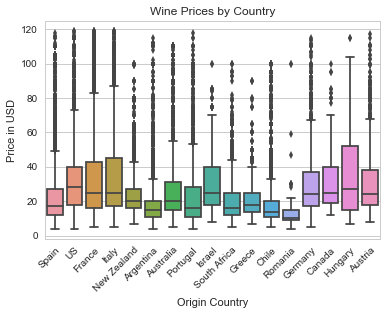

In [35]:
prices_by_country = data[["price", "country"]].dropna(how = "any")

# Remove all data greater than the 98th percentile
val = prices_by_country["price"].quantile(0.98)
prices_by_country = prices_by_country[prices_by_country["price"] < val]

# Only consider countries where at least 100 wines have been reviewed
prices_by_country = prices_by_country.groupby("country").filter(lambda x: (x["price"].count() >= 100))

# Creating a boxplot
ax = sns.boxplot(x="country", y = "price", data=prices_by_country)

# Setting title 
ax.set_title("Wine Prices by Country")

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Price in USD")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

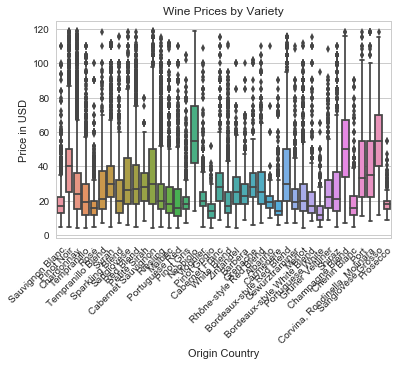

In [89]:
prices_by_variety = data[["price", "variety"]].dropna(how = "any")

# Remove all data greater than the 98th percentile
val = prices_by_variety["price"].quantile(0.98)
prices_by_variety = prices_by_variety[prices_by_variety["price"] < val]

# Only consider varieties where at least 500 wines have been reviewed
prices_by_variety = prices_by_variety.groupby("variety").filter(lambda x: (x["price"].count() >= 500))

# Creating a boxplot
ax = sns.boxplot(x="variety", y = "price", data=prices_by_variety)

# Setting title 
ax.set_title("Wine Prices by Variety")

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Price in USD")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

### Ratings versus Price 

Is there a correlation? 

(this takes a while to plot)

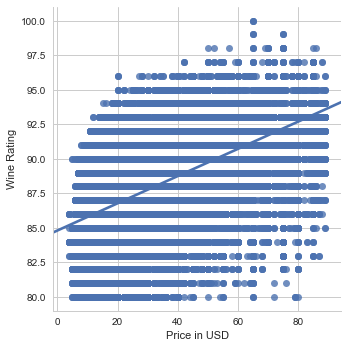

In [90]:
ratings_by_price = data[["price", "points"]]

# Remove all data greater than the 98th percentile
val = prices_by_variety["price"].quantile(0.98)
ratings_by_price = ratings_by_price[ratings_by_price["price"] < val]

ax = sns.lmplot(x = "price", y = "points", data = ratings_by_price)

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Price in USD", ylabel = "Wine Rating")

plt.show()

## Predicting Wine Scores from Text Descriptions

We use the following classification system provided by the website: 

**Classic:** 98-100

**Superb:** 94-97

**Excellent:** 90-93

**Very Good:** 87-89

**Good:** 83-86

**Acceptable:** 80-82

Since the website does not have a comprehensive list of scores, our classifier will only be able to differentiate between "high quality" wines. 

We will be using a RNN with GRU units. 

In [49]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input, Activation, LSTM, GRU, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AffinityPropagation

C:\Users\mandy\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Preparing Data for Classification

In [93]:
# Converting Points to Classes 

def points_to_class(points):
    if points in range(80,83):
        return 0
    elif points in range(83,87):
        return 1
    elif points in range(87,90):
        return 2
    elif points in range(90,94):
        return 3
    elif points in range(94-98):
        return 4
    else:
        return 5
    
data["rating"] = data["points"].apply(points_to_class)

In [92]:
""" Ratings are unbalanced """

# Class 4 is also missing
data["rating"].value_counts()

2    51539
1    44740
3    41767
5     6443
0     6441
Name: rating, dtype: int64

In [94]:
# New classification

def points_to_class(points):
    if points in range(80,83):
        return 0
    elif points in range(83,87):
        return 1
    elif points in range(87,90):
        return 2
    elif points in range(90,94):
        return 3
    else:
        return 4
    
data["rating"] = data["points"].apply(points_to_class)

In [65]:
# Fixed parameters

num_classes = 6
embedding_dim = 300 
epochs = 10
batch_size = 128
max_len = 50

class_weights = {0: 7,
                1: 1,
                2: 1, 
                3: 1,
                4: 7}


In [ ]:
# One hot encoding target
def onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr.astype(int)).reshape(-1)]

y = onehot(data["rating"], num_classes)

# Train, validation split (test is on another set)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data["description"], y, test_size = 0.05)


# Prepare embeddings 
# Embedding file not contained in repo. Download from https://nlp.stanford.edu/projects/glove/
# I am using glove.840B.300d.zip

embeddings_index = {}

f = open("glove.840B.300d.txt", encoding = "utf8")

for line in f:
    values = line.split()
    word = ''.join(values[:-embedding_dim])
    coefs = np.asarray(values[-embedding_dim:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
    
# train tokenizer 
tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(X_train)

# fit tokenizer
sequences_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences_train, maxlen=max_len)

sequences_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(sequences_val, maxlen = max_len)

word_index = tokenizer.word_index

word_index = tokenizer.word_index
                
# create embedding layer 
# We can stipulate Out of Vocabulary word vectors here 
# In this case, they are initialized to zero vector
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
        
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Training the Classifier

In [77]:
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False) 
input= Input(shape=(max_len, ), dtype = 'int32')
embedded_sequences = embedding_layer(input) 
x = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input, outputs=output)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback = [checkpoint, early]
        
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=callback, class_weight = class_weights)

Train on 143383 samples, validate on 7547 samples
Epoch 1/10
102528/143383 [====================>.........] - ETA: 141s - loss: 0.9405 - acc: 0.5791

KeyboardInterrupt: 

### Evaluate on Testing Set 

In [82]:
from sklearn.metrics import accuracy_score

test = pd.read_csv("winemag-data-130k-v2.csv", index_col = False)
test["rating"] = test["points"].apply(points_to_rating)

sequences_test = tokenizer.texts_to_sequences(test["description"])
X_test = pad_sequences(sequences_test, maxlen=max_len)

# Predictions
pred_test = model.predict(X_test)
pred_test = [np.argmax(x) for x in pred_test]

# Actual
true_test = onehot(test["rating"], 6)
true_test = [np.argmax(x) for x in true_test]

# Find accuracies
accuracy = accuracy_score(true_test, pred_test)

In [94]:
print("The total accuracy is ", accuracy)

0.6246624246947396

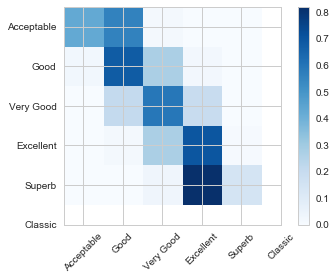

In [104]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb", "Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)

plt.show()

In [60]:
word_occurrence = data["cleaned_description"].str.split(expand=True).stack().value_counts()
word_occurrence.head()

wine       61472
flavors    47702
fruit      36520
aromas     29785
black      24347
dtype: int64

In [83]:
sum(word_occurrence)

2619762

In [68]:
def points_to_class(points):
    if points in range(80,83):
        return 0
    elif points in range(83,87):
        return 1
    elif points in range(87,90):
        return 2
    elif points in range(90,94):
        return 3
    elif points in range(94-98):
        return 4
    else:
        return 5
    
data["rating"] = data["points"].apply(points_to_class)